# Career Booster Python & Data Science

## Session 4 : Introduction au Deep Learning

*** 


Ce notebook est dédié à une introduction à l'utilisation d'un modèle simple de Deep Learning. Nous allons nous baser sur un jeu de données d'images sur lequel nous allons entraîner un modèle de classification permettant de distinguer ces images entre elles. Le but est évidemment ensuite de pouvoir classifier de nouvelles images jamais vues auparavant.

## Import des bibliothèques

In [1]:
# --- Manipulation de données
import numpy as np
import pandas as pd

# --- Display
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sn

# --- Machine Learning
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import CSVLogger

# A. Les données

Les données sont issues du dataset *fashion_mnist* qui est une référence au jeu de données *MNIST*, provenant du [NIST][1] (**N**ational **I**nstitute of **S**tandards and **T**echnology).
La version originale du *MNIST dataset* consiste en 70 000 images de chiffres écrits à la main, images en noir & blanc et de taille 28x28 pixels (donc plutôt basse résolution). Ce jeu de données a été intensément utilisé par la communauté de Data Science pour mettre au point des modèles les plus performants possible, jusqu'à atteindre un taux d'erreur de 0.17% !

Nous allons ici traiter un cas similaire mais au lieu de chiffres il s'agit de photos de vêtements, également en noir & blanc et également de taille 28x28.

L'objectif va être de créer un modèle apprenant à classer ces images automatiquement. Une fois le modèle appris, nous pourrons classer des images nouvelles, c'est-à-dire des images que le modèle n'aura jamais vu !

[1]: https://en.wikipedia.org/wiki/MNIST_database

### 1. Import des données

Les données sont directement accessibles via Tensorflow / Keras. La première fois que vous lancez ce notebook, vous aurez à télécharger ces données (et ce téléchargement est fait automatiquement, vous n'avez rien à faire). Ensuite, ce ne sera plus la peine.

In [2]:
fashion_mnist = keras.datasets.fashion_mnist
(images_train, labels_train), (images_test, labels_test) = fashion_mnist.load_data()

### 2. Etude préliminaire des données

Keras nous permet directement d'accéder à une séparation de ce jeu de données en *deux sous jeux de données* : 
- un qui sera utilisé pour l'apprentissage : 60 000 images de 28 par 28 pixels
- un qui sera utilisé our le test : 10 000 images de 28 par 28 pixels également

Le premier sera donc utilisé pour **entraîner** le modèle tandis que le second sera utilisé pour **confronter** le modèle à des données qu'il n'a jamais vu. Nous pourrons donc réellement avoir une idée de la performance du modèle.

In [3]:
images_train.shape

(60000, 28, 28)

In [4]:
labels_train.shape

(60000,)

Les données *target* (le *y_train* ici) correspondent aux classes qu'il va falloir apprendre puis prédire.

In [5]:
labels_train

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

Elles sont ici codées de façon numérique mais nous connaissons la correspondance avec les vrais noms de classe :

In [6]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
nb_classes = len(class_names)

### 3. Visualisation

Il est indispensable de toujours essayer (lorsque c'est possible) de visualiser les données que nous allons avoir à traiter.

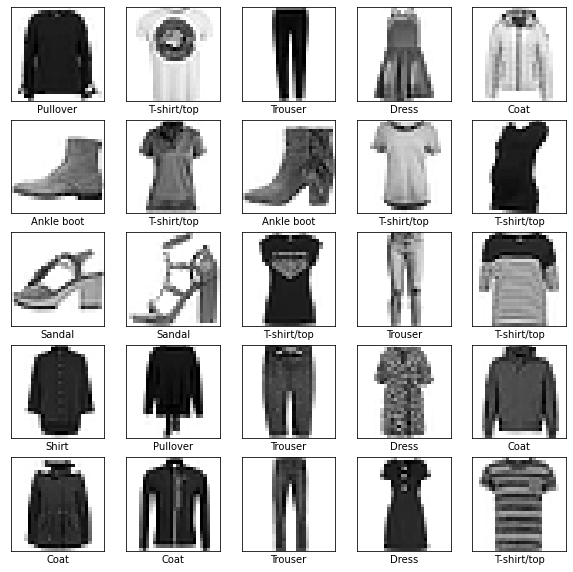

In [11]:
nb_images = images_train.shape[0]

random_indices = np.random.randint(0, nb_images, 25)

plt.figure(figsize=(10,10))

for iCpt, iIdx in enumerate(random_indices):
    plt.subplot(5, 5, iCpt+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images_train[iIdx], cmap=plt.cm.binary)
    plt.xlabel(class_names[labels_train[iIdx]])

plt.show()

### 4. Jeu de données de validation

Au sein du jeu de données d'apprentissage, nous allons créer un nouveau sous jeu de données qui correspond au jeu de *validation*. A la fin de chaque époque d'apprentissage, le modèle va se tester lui-même sur ce jeu de données et faire évoluer ses paramètres en fonction du résultat de ce test. Les données ne sont donc pas directement utilisées pour l'apprentissage mais elles servent malgré tout à la construction et à la convergence du modèle. Ce jeu de données est donc différent du jeu de données *test*.

Souvent, nous divisons le jeu de données d'apprentissage comme suit :
- 70% de données d'apprentissage
- 20% de données de validation
- 10% de données de test

Ces valeurs ne sont qu'indicatives et dépendent du contexte et du type de données. Ces valeurs font d'ailleurs partie des hyper-paramètres qu'il est possible, en fin de pipeline, de fine-tuner également.

Afin d'effectuer la division de notre jeu de données, nous allons utiliser une fonction dédiée provenant de la bibliothèque scikit learn :

In [12]:
X_train, X_val, y_train, y_val = train_test_split(
    images_train,
    labels_train,
    test_size=0.2
)

In [13]:
X_train = X_train / 255.0
X_val = X_val / 255.0
images_test = images_test / 255.0

In [14]:
len(X_train)

48000

Les classes sont exprimées sous forme numérique -> nécessité de les exprimer en texte

## B. L'apprentissage

Nous allons ici utiliser un modèle **séquentiel** simple, c'est-à-dire un modèle composé :
- d'une couche d'entrée : c'est par là que les données vont entrer dans le modèle. Il y aura **28x28 neurones** d'entrée puisque nos images ont une dimension de 28 par 28 pixels
- d'une seule couche cachée contenant 128 neurones
- d'une couche de sortie : c'est par là que les prédictions du modèle vont être récupérées. Il y aura **10 neurones** ici puisqu'il y a 10 classes de vêtements à prédire.

### 1. Création du modèle

Nous créons le modèle via l'API de Keras, désormais complètement intégrée à Tensorflow (développé par Google).
Pour ce faire, nous additionnons les couches les unes aux autres, chacune avec des propriétés particulières.

In [42]:
"""
Initialisation du modèle
"""
model = tf.keras.Sequential()

"""
1. Ajout de la couche d'entrée.
On utilise la couche "Flatten" qui va "aplatir" nos données en entrée.
En effet, ce type de réseaux de neurones ne peut que prendre que des vecteurs 1D en entrée.
Il est donc nécessaire de transformer cette matrice 2D en un vecteur 1D de 784 valeurs.
"""
model.add(
    tf.keras.layers.Flatten(
        input_shape=[28, 28]
    )
)

"""
2. Ajout de la couche cachée de 128 neurones
"""
model.add(tf.keras.layers.Dense(128))
model.add(tf.keras.layers.ReLU())

"""
3. Ajout de la couche de sortie.
"""
model.add(tf.keras.layers.Dense(nb_classes))

Jetons un coup d'oeil sur ce modèle :

In [43]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               100480    
_________________________________________________________________
re_lu_2 (ReLU)               (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


Chaque couches (*layer*) possède un vecteur de poids ainsi qu'un vecteur de biais. C'est cette architecture qui permet l'apprentissage et ce sont ces valeurs (principalement) que le modèle va essayer de modifier lors de l'apprentissage afin que les prédictions que le modèle effectue soient de plus en plus proches de la référence qui lui ai donné.

A noter que par défaut, les biais sont tous initialisés à 0 en début d'apprentissage.

In [48]:
model.layers[1].weights

[<tf.Variable 'dense_4/kernel:0' shape=(784, 128) dtype=float32, numpy=
 array([[ 0.25745872, -0.06723904,  0.04580022, ...,  0.07883938,
          0.17137177, -0.04521084],
        [ 0.13027479,  0.01223034,  0.02422785, ..., -0.07760706,
         -0.493891  , -0.15121329],
        [ 0.05481884, -0.07841545, -0.00470988, ..., -0.11027149,
          0.10223739, -0.20528121],
        ...,
        [-0.26144692, -0.05491082, -0.20876257, ...,  0.07166447,
         -0.09897302, -0.0089164 ],
        [-0.31930196,  0.01134623, -0.12139426, ...,  0.1571278 ,
         -0.16325538, -0.07189622],
        [ 0.08308715, -0.08810923, -0.00300434, ..., -0.12924208,
         -0.28518146, -0.05889624]], dtype=float32)>,
 <tf.Variable 'dense_4/bias:0' shape=(128,) dtype=float32, numpy=
 array([ 1.18181750e-01, -3.24522518e-02,  2.66168237e-01, -2.37824135e-02,
         9.82463211e-02,  4.36828673e-01, -6.80518672e-02,  6.66121393e-02,
         5.52789152e-01,  2.88810134e-01, -2.61817306e-01, -3.64878

Le modèle étant maintenant créé, il est nécessaire de le compiler.

In [45]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Il est possible d'enregistrer les valeurs intermédiaires de l'apprentissage dans un fichier CSV afin de pouvoir les retrouver ensuite. Pour cela, il est nécessaire de faire appel à la classe CSVLogger dédiée et de l'inclure ensuite dans l'appel à la fonction *fit* du modèle (cf. ci-après).


Sachez également que nous sauvegarderons aussi ces valeurs dans une variable dédiée.

In [46]:
csv_log = CSVLogger("results.csv")

### 2. Entraînement du modèle

Nous pouvons maintenant entraîner le modèle avec comme arguments :
- *X_train* : les données d'entraînement, c'est-à-dire 48 000 images
- *y_train* : les 48 000 labels correspondant
- *epochs* : un nombre d'itération, c'est-à-dire de fois où le modèle va effectuer une passe sur toutes les données d'apprentissage
- *validation_data* : les données de validation, elles aussi composées d'images et de labels correspondants
- *callbacks* : une liste des fonctions à appeler à chaque fin d'époques / d'itérations.

In [47]:
nb_epochs = 10

history = model.fit(X_train,
                    y_train,
                    epochs=nb_epochs,
                    validation_data=(X_val, y_val),
                    callbacks=[csv_log])

Epoch 1/10
1500/1500 [==============================] - 2s 1ms/step - loss: 0.6572 - accuracy: 0.7706 - val_loss: 0.4162 - val_accuracy: 0.8536
Epoch 2/10
1500/1500 [==============================] - 2s 1ms/step - loss: 0.4032 - accuracy: 0.8569 - val_loss: 0.3767 - val_accuracy: 0.8619
Epoch 3/10
1500/1500 [==============================] - 2s 1ms/step - loss: 0.3465 - accuracy: 0.8744 - val_loss: 0.3746 - val_accuracy: 0.8674
Epoch 4/10
1500/1500 [==============================] - 2s 1ms/step - loss: 0.3223 - accuracy: 0.8838 - val_loss: 0.3415 - val_accuracy: 0.8791
Epoch 5/10
1500/1500 [==============================] - 2s 1ms/step - loss: 0.3013 - accuracy: 0.8900 - val_loss: 0.3585 - val_accuracy: 0.8702
Epoch 6/10
1500/1500 [==============================] - 2s 1ms/step - loss: 0.2799 - accuracy: 0.8958 - val_loss: 0.3319 - val_accuracy: 0.8835
Epoch 7/10
1500/1500 [==============================] - 2s 1ms/step - loss: 0.2718 - accuracy: 0.8985 - val_loss: 0.3178 - val_accuracy:

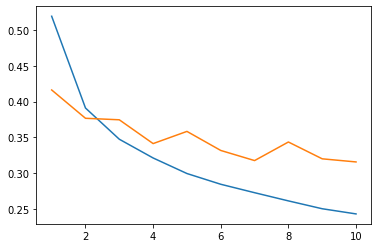

In [49]:
plt.plot(range(1, nb_epochs+1), history.history["loss"])
plt.plot(range(1, nb_epochs+1), history.history["val_loss"])
plt.show()

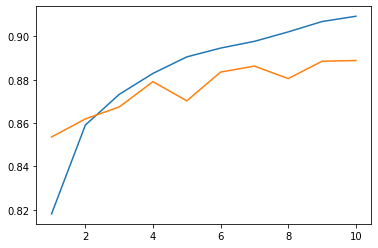

In [50]:
plt.plot(range(1, nb_epochs+1), history.history["accuracy"])
plt.plot(range(1, nb_epochs+1), history.history["val_accuracy"])
plt.show()

### 3. Visualisation des résultats

L'apprentissage est maintenant terminé. Nous pouvons visualiser l'évolution des métriques que nous avons définies plus haut :

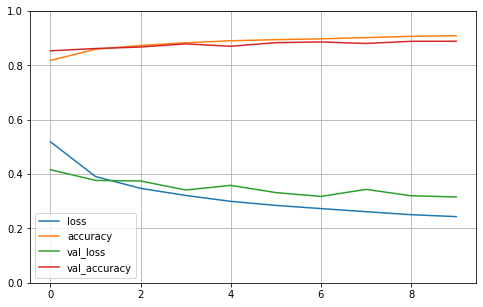

In [51]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [52]:
results = pd.read_csv("results.csv", index_col='epoch')
results

,accuracy,loss,val_accuracy,val_loss
epoch,,,,
0,0.818146,0.518992,0.853583,0.416236
1,0.859083,0.391060,0.861917,0.376745
2,0.873208,0.347549,0.867417,0.374644
3,0.882896,0.321421,0.879083,0.341471
4,0.890500,0.299741,0.870250,0.358463
5,0.894562,0.284771,0.883500,0.331900
6,0.897667,0.273023,0.886250,0.317798
7,0.902021,0.261598,0.880500,0.343685
8,0.906792,0.250642,0.888500,0.320238


### 4. Evaluation du modèle

Le modèle est entraîné et nous considérons que les valeurs de *loss* sont suffisament hautes pour arrêter l'apprentissage. Nous pouvons donc désormais *utiliser* ce modèle pour faire de la prédiction.

Nous allons alors commencer par effectuer des prédictions sur le jeu de données test, jeu de données, pour rappel, que le modèle n'a **jamais** vu mais pour lequel nous connaissons le label à prédire — c'est tout l'intérêt du jeu de test !

In [53]:
test_loss, test_acc = model.evaluate(images_test,  labels_test, verbose=2)

313/313 - 0s - loss: 0.3413 - accuracy: 0.8798


Nous voyons ici que l'*accuracy* est d'environ 85%, une valeur inférieure à ce que nous avons observé sur le jeu de train d'une part et sur le jeu de validation d'autre part.
C'est totalement normal ! Le jeu de données test correspond à des données totalement nouvelles pour le modèle, il est donc logique qu'il s'en sorte un peu moins bien que sur les données qu'il a eu l'occasion de traiter de nombreuses fois (cf. nombre d'époques).

### 5. Prédictions

On effectue une prédiction sur trois images du jeu de données de test (jamais vue auparavant par le modèle)

In [54]:
X_new = images_test[:3]
y_proba = model.predict(X_new)
y_proba

array([[ -9.894917  , -19.094547  , -13.259018  , -18.972128  ,
        -12.426113  ,   1.6464795 ,  -6.155097  ,   1.6397913 ,
         -9.134999  ,   5.7116055 ],
       [ -1.424863  , -16.55757   ,   6.7604337 , -12.35979   ,
          0.18069935, -12.269792  ,   2.0487473 , -25.812304  ,
        -11.666492  , -18.186747  ],
       [ -1.0250095 ,  16.199387  ,  -5.4936295 ,  -3.6552038 ,
         -3.819744  , -19.033165  ,  -8.786997  , -28.136023  ,
        -13.928063  , -13.334831  ]], dtype=float32)

Si l'on souhaite avoir des classes prédites plutôt que des probas d'appartenance

In [57]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

predictions = probability_model.predict(images_test)

In [ ]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [62]:
np.round(predictions[0], 3)

array([0.   , 0.   , 0.   , 0.   , 0.   , 0.017, 0.   , 0.016, 0.   ,
       0.967], dtype=float32)

In [63]:
np.argmax(predictions[0])

9

In [64]:
labels_test[0]

9

In [65]:
def plot_image_and_probas(
    image,
    predictions,
    true_label,
    labels
):
    """Description
    
    Parameters
    ----------
    image : 2D matrix
    
    predictions : 2D matrix

    true_label : 
    
    labels : list of str
        All possible labels
    
    Returns
    -------
    """
    fig = plt.figure(figsize=(8, 4),
                     constrained_layout=True)
    
    spec = gridspec.GridSpec(ncols=2,
                             nrows=1,
                             figure=fig)
    
    fig.add_subplot(spec[0, 0])
    
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(image, cmap = plt.cm.binary)

    predicted_label = np.argmax(predictions)

    color = 'blue'
    if predicted_label != true_label:
        color = 'red'

    disp_pred_label = labels[predicted_label]
    disp_pred = round(100*np.max(predictions))/100
    disp_true_label = labels[true_label]
    plt.xlabel(
        f"Pred.: {disp_pred_label}, proba: {disp_pred}, true label: {disp_true_label}",
        color=color)

    # --- Second subplot
    fig.add_subplot(spec[0, 1])
    
    plt.grid(False)
    plt.xticks(range(10))
    
    plt_bar = plt.bar(range(len(labels)),
                       predictions,
                       color="#777777")
    
    plt_bar[predicted_label].set_color('red')
    plt_bar[true_label].set_color('blue')
    
    locs, _ = plt.xticks()
    plt.xticks(ticks=locs, labels=labels, rotation=45)
    
    plt.show()

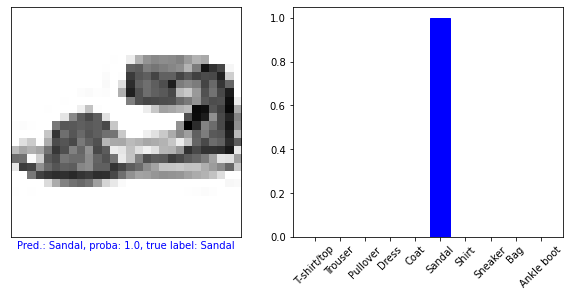

In [94]:
idx = np.random.randint(0, len(images_test), 1)[0]

plot_image_and_probas(images_test[idx],
                      predictions[idx],
                      labels_test[idx],
                      class_names)

idx = 9366

### 6. Analyse des limites du modèle

Le jeu de données test va nous servir à étudier où le modèle est moins performant :
- est-ce pour toutes les classes ?
- ou sont-ce seulement certaines classes qui sont plus dures à modéliser ?

Pour cela, nous allons utiliser une matrice de confusion, construite à partir des résultats des prédictions sur le jeu de données test. Une telle matrice nous renseigne sur :
- le nombre de faux positifs : *bag* prédit alors que c'était autre chose
- le nombre de vrais positis : *bag* prédit et c'est effectivement un *bag*
- le nombre de faux négatifs : *bag* **non prédit** alors que c'était bien un *bag*
- le nombre de vrais négatifs : *bag* **non prédit** et ce n'était bien **pas un *bag***

La matrice de confusion est une façon simple, rapide mais très pertinente pour juger la performance d'un modèle.

In [84]:
confusion_matrix = tf.math.confusion_matrix(
    labels_test,
    np.argmax(predictions, axis=1),
    num_classes=nb_classes
)
confusion_matrix = np.array(confusion_matrix)

In [85]:
confusion_matrix

array([[847,   0,  16,  35,   5,   1,  89,   0,   7,   0],
       [  3, 968,   2,  20,   4,   0,   2,   0,   1,   0],
       [ 17,   0, 798,  15,  79,   0,  90,   0,   1,   0],
       [ 24,   6,  10, 921,  11,   0,  26,   0,   2,   0],
       [  2,   0, 106,  56, 745,   0,  91,   0,   0,   0],
       [  0,   0,   0,   1,   0, 965,   0,  23,   1,  10],
       [152,   0,  76,  35,  44,   0, 683,   0,  10,   0],
       [  0,   0,   0,   0,   0,  16,   0, 941,   0,  43],
       [  3,   0,   5,   6,   2,   3,   6,   6, 969,   0],
       [  0,   0,   0,   0,   0,  13,   1,  25,   0, 961]], dtype=int32)

Même s'il n'est pas trop compliqué de lire cette matrice, il est beaucoup plus parlant de la représenter sous forme d'image :

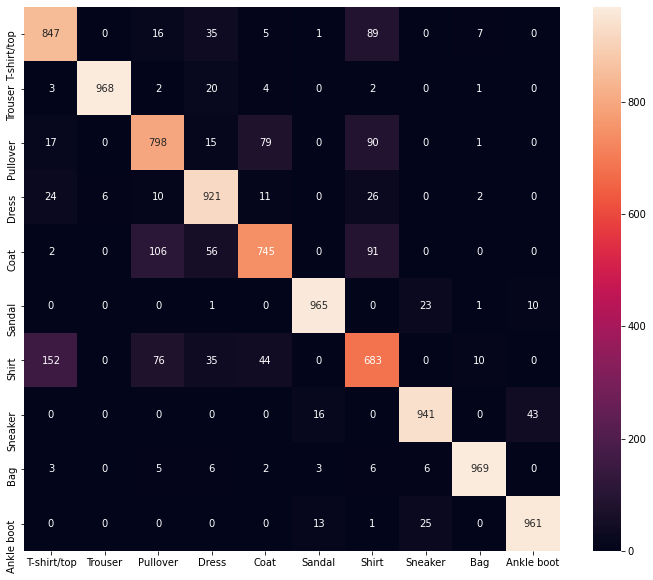

In [86]:
df_cm = pd.DataFrame(np.array(confusion_matrix),
                     index = class_names,
                     columns = class_names)
plt.figure(figsize = (12,10))
sn.heatmap(df_cm, annot=True, fmt="G");

Observations : A VOUS !